# Score Based Model

## ノイズスケジュールの定義

線形にノイズの分散が増加するシンプルなスケジュールを定義します。

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

# ハイパーパラメータ
np.random.seed(42)
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1. - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)

def noise_schedule(t):
    sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod[t])
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod[t])
    return sqrt_alpha_cumprod_t, sqrt_one_minus_alpha_cumprod_t

## スコアネットワークの構築

簡単なMLP（多層パーセプトロン）をスコアネットワークとして使用します。入力はノイズが加えられたデータとタイムステップの埋め込みです。

In [13]:
class ScoreNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embed_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + time_embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.time_embed = nn.Linear(1, time_embed_dim)

    def forward(self, x, t):
        # タイムステップを埋め込み
        t_embed = self.time_embed(t[:, None].float() / timesteps)
        h = torch.cat([x, t_embed], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

## 損失関数の定義

ノイズを加えたデータから推定されたスコアと、真のノイズの負の値を近づける損失関数を使用します。

In [14]:
def loss_fn(model, x_0, t):
    sqrt_alpha_cumprod_t, sqrt_one_minus_alpha_cumprod_t = noise_schedule(t)
    noise = torch.randn_like(x_0)
    # ノイズを加えたデータ
    x_t = sqrt_alpha_cumprod_t[:, None] * x_0 + sqrt_one_minus_alpha_cumprod_t[:, None] * noise
    # スコアネットワークによるスコアの推定
    predicted_score = model(x_t, t)
    # 真のスコアはノイズの負の値に比例する（重み付けは省略）
    target_score = -noise
    loss = F.mse_loss(predicted_score, target_score)
    return loss

## 学習ループ

簡単な学習ループの例です。

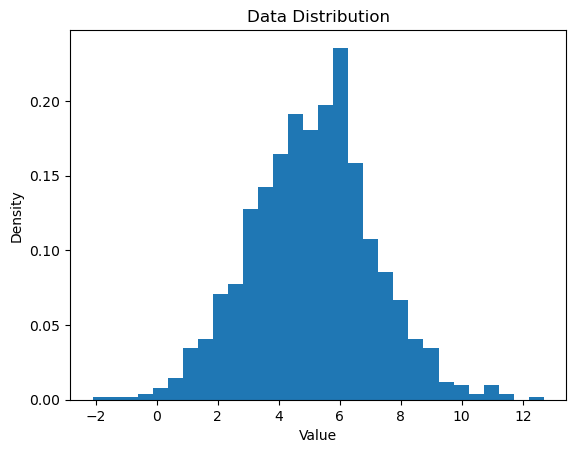

In [33]:
# データ生成 (例として1次元のガウス分布からのサンプル)
def generate_data(n_samples=500):
    return torch.randn(n_samples, 1) * 2 + 5

data = generate_data(1000)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# データの可視化
plt.hist(data.numpy(), bins=30, density=True)
plt.title("Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

実際に学習

Epoch [25/500], Loss: 0.3515
Epoch [50/500], Loss: 0.1492
Epoch [75/500], Loss: 0.4906
Epoch [100/500], Loss: 0.2308
Epoch [125/500], Loss: 0.3025
Epoch [150/500], Loss: 0.4383
Epoch [175/500], Loss: 0.3809
Epoch [200/500], Loss: 0.3859
Epoch [225/500], Loss: 0.6692
Epoch [250/500], Loss: 0.2898
Epoch [275/500], Loss: 0.3974
Epoch [300/500], Loss: 0.2444
Epoch [325/500], Loss: 0.5815
Epoch [350/500], Loss: 0.5031
Epoch [375/500], Loss: 0.3509
Epoch [400/500], Loss: 0.1945
Epoch [425/500], Loss: 0.2805
Epoch [450/500], Loss: 0.3624
Epoch [475/500], Loss: 0.2273
Epoch [500/500], Loss: 0.3890


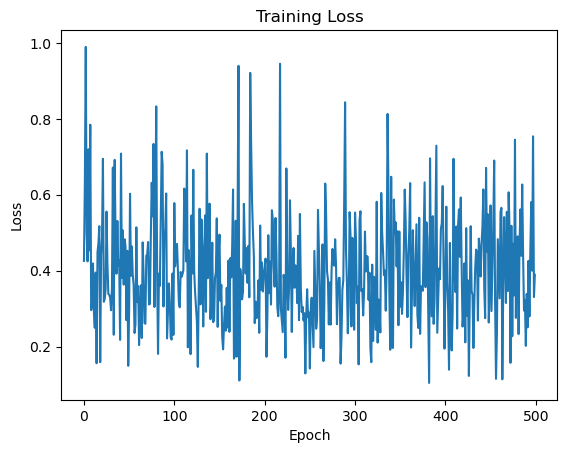

In [36]:
# モデルとオプティマイザの初期化
input_dim = 1
hidden_dim = 128
time_embed_dim = 32
model = ScoreNet(input_dim, hidden_dim, time_embed_dim)
optimizer = Adam(model.parameters(), lr=1e-3)

loss_history = []
epochs = 500
for epoch in range(epochs):
    for batch in dataloader:
        x_0 = batch[0]
        t = torch.randint(0, timesteps, (x_0.shape[0],))
        loss = loss_fn(model, x_0, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
# 損失のプロット
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

サンプリング関数を定義し実行

In [37]:
@torch.no_grad()
def sample(model, n_samples, device="cpu"):
    x_t = torch.randn(n_samples, input_dim).to(device)
    for i in reversed(range(timesteps)):
        t = torch.ones(n_samples, dtype=torch.long).to(device) * i
        sqrt_alpha_t = torch.sqrt(alphas[i])
        beta_t = betas[i]
        score_t = model(x_t, t)
        # 簡易的な逆拡散ステップ (より正確には確率微分方程式の離散化が必要)
        x_t = (1 / sqrt_alpha_t) * (x_t - (beta_t / torch.sqrt(1 - alpha_cumprod[i])) * score_t)
        if i > 0:
            noise = torch.randn_like(x_t)
            posterior_variance = beta_t
            x_t = x_t + torch.sqrt(posterior_variance) * noise
    return x_t.cpu().numpy()

# サンプリングの実行と結果の可視化
model.eval()
sampled_data = sample(model, n_samples=10000)

In [38]:
print("sampled_data の最小値:", np.min(sampled_data))
print("sampled_data の最大値:", np.max(sampled_data))
print("sampled_data の最初の10要素:", sampled_data[:10])

sampled_data の最小値: -65270.18
sampled_data の最大値: 3581.7283
sampled_data の最初の10要素: [[   650.7965 ]
 [ -7052.5845 ]
 [  1775.0131 ]
 [  1506.1566 ]
 [   589.81274]
 [-37869.625  ]
 [-14240.12   ]
 [  2312.543  ]
 [ -5078.0415 ]
 [-18748.088  ]]


ヒストグラムによる可視化

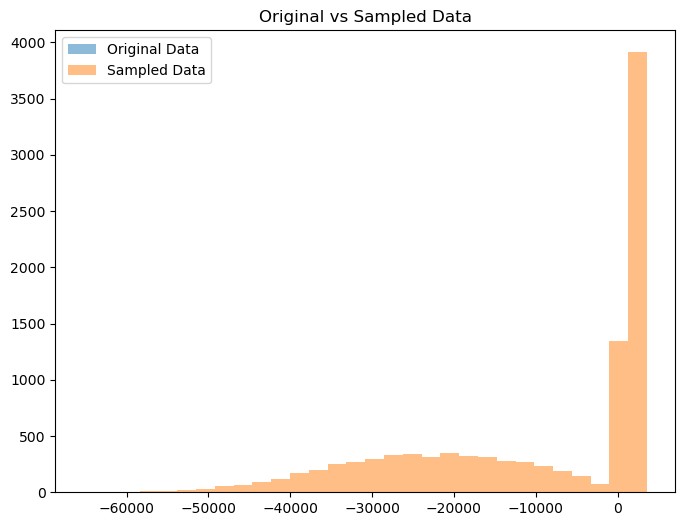

In [39]:
plt.figure(figsize=(8, 6))
plt.hist(data.numpy(), bins=30, alpha=0.5, label='Original Data')
plt.hist(sampled_data, bins=30, alpha=0.5, label='Sampled Data')
plt.legend()
plt.title('Original vs Sampled Data')
plt.show()

In [ ]:
# カーネル密度推定関数（以前のコードから）
def gaussian_kde_1d(data, x, bandwidth):
    """
    1次元データに対するガウシアンカーネル密度推定

    Args:
        data (np.ndarray): 1次元のデータ配列
        x (np.ndarray): 密度を推定するx座標の配列
        bandwidth (float): カーネルのバンド幅

    Returns:
        np.ndarray: x座標における密度推定値
    """
    n = len(data)
    kde = np.zeros_like(x)
    for i in range(n):
        kde += norm.pdf(x, loc=data[i], scale=bandwidth)
    return kde / (n * bandwidth)

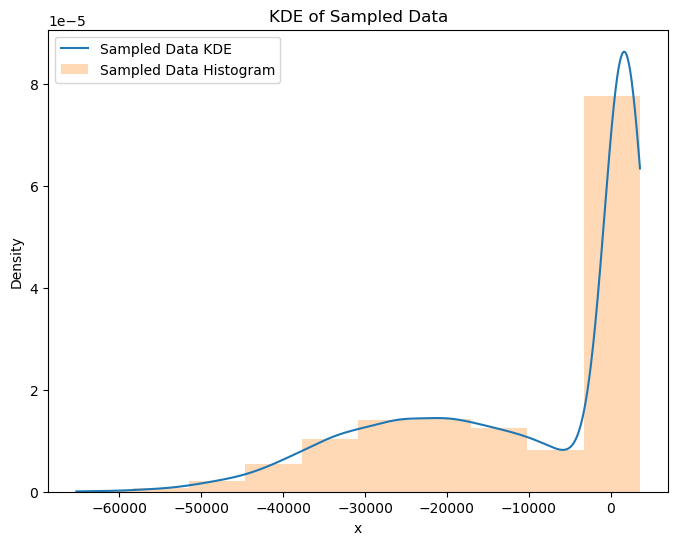

In [41]:
# カーネル密度推定
kde = gaussian_kde(sampled_data.flatten())
x_range = np.linspace(sampled_data.min() - 1, sampled_data.max() + 1, 1000)  # 適切な範囲を設定
density = kde(x_range)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(x_range, density, label='Sampled Data KDE')
plt.hist(sampled_data, density=True, alpha=0.3, label='Sampled Data Histogram')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('KDE of Sampled Data')
plt.legend()
plt.show()